In [1]:
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import numpy as np
import scipy.io as sio
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
import random
from collections import Counter
np.random.seed(0)
random.seed(0)

# 





In [2]:

# cross-validation  with baseline include 0 class . accuracy =1- err  err=abs(y_pred-y_test)/3  

def valid(x,y,opt):
    if x.shape[1] == 15 :
        featureName=['VarBR','Varpp','VarIn','VarEx', 'meanBR',\
             'meanIn', 'meanEx' ,'r1 BR','r1 PP','r1 IN','r1 EX','r2 BR','r2 PP','r2 IN','r2 EX']
    if x.shape[1] == 18 :
        featureName=['CovBR','CovPP','CovIN','CovEX', 'meanBR',\
             'meanIN', 'meanEX' ,'r1 BR','r1 PP','r1 IN','r1 EX','r2 BR','r2 PP','r2 IN','r2 EX',\
            'meanHR','sdnn','rmsrr']
    thres=0.9
    acc=[]
    impt=[]
    scale=y[0,:]
    group=y[1,:]
    acc_max_temp=0  
    tree_max=[]
    a=opt[2]
    b=opt[3]
    ran=0
    if opt[0]=='kfold':
        rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3,random_state=ran)

        
        for train_ind, test_ind in rkf.split(x,scale):
            #print("%s %s" % (train_ind, test_ind))
            #print(test_ind)
            X_train=x[train_ind] 
            X_test=x[test_ind]
            y_train=scale[train_ind] 
            y_test=scale[test_ind]
            
            acc_temp=np.zeros((8,))
            impt_temp=np.zeros((8,x.shape[1]))
            
            
            for i in range(8):
                if  opt[1]=='tree':
                    tree1 = DecisionTreeRegressor(max_depth=a,random_state=ran).fit(X_train,y_train)
                if  opt[1]=='forest':
                    tree1 = RandomForestRegressor(max_depth=b,n_estimators=40,max_features=None,random_state=ran).fit(X_train,y_train)

                y_p=tree1.predict(X_test)
                acc_t = 1-abs(y_p.astype('float')-y_test.astype('float'))/10
                
                acc_temp[i]=np.mean(acc_t)
                impt_temp[i,:]=tree1.feature_importances_
                if acc_temp[i] >= thres:
                    acc_max_temp=acc_temp[i]
                    tree_max.append(tree1)

            max=np.max(acc_temp)
            ind=np.where(acc_temp == np.amax(acc_temp))
            ind=np.min(ind)
            impt_max=impt_temp[ind,:]
            acc.append(max) 
            impt.append(impt_max)


    if opt[0]=='group':
        rkf = LeaveOneGroupOut()

        for train_ind, test_ind in rkf.split(x,scale,group):
            #print("%s %s" % (train_ind, test_ind))
            #print(test_ind)
            X_train=x[train_ind] 
            X_test=x[test_ind]
            y_train=scale[train_ind] 
            y_test=scale[test_ind]
            
            acc_temp=np.zeros((8,))
            impt_temp=np.zeros((8,x.shape[1]))
            
             
            for i in range(8):
                if  opt[1]=='tree':
                    tree1 = DecisionTreeRegressor(max_depth=a).fit(X_train,y_train)
                if  opt[1]=='forest':
                    tree1 = RandomForestRegressor(max_depth=b,n_estimators=40,max_features=None).fit(X_train,y_train)

                y_p=tree1.predict(X_test)
                acc_t = 1-abs(y_p.astype('float')-y_test.astype('float'))/10
                acc_temp[i]=np.mean(acc_t)
                impt_temp[i,:]=tree1.feature_importances_
                if acc_temp[i] >= thres:
                    acc_max_temp=acc_temp[i]
                    tree_max.append(tree1)

            max=np.max(acc_temp)
            ind=np.where(acc_temp == np.amax(acc_temp))
            ind=np.min(ind)
            impt_max=impt_temp[ind,:]
            acc.append(max) 
            impt.append(impt_max)

    impt=np.array(impt) 
    importance1=np.mean(impt,axis=0)
    seq=np.argsort(importance1)
    featureName=np.array(featureName)
    featureName1=featureName[seq]
    importance1=importance1[seq]
    importance1=np.flip(importance1)
    featureName1=np.flip(featureName1)
        
    acc=np.array(acc)
    acc_mean=np.mean(acc)
    print('{n:.3f}'.format(n=acc_mean))
    
    return acc,featureName1,importance1,tree_max,acc_mean

def test(X_test,y_test,tree):
    acc_temp=[]
    acc_max_temp=0
    for i in range(len(tree)):
        
        y_p=tree[i].predict(X_test)
        acc_t = 1-abs(y_p.astype('float')-y_test.astype('float'))/10
        
        acc_temp.append(np.mean(acc_t))
        if np.mean(acc_t) >= acc_max_temp:
            acc_max_temp=np.mean(acc_t)
            tree_max=tree[i]
            tree_max_ind=i       
            y=np.stack((y_test, y_p))
    print('{n:.3f}'.format(n=acc_max_temp))
    return acc_max_temp,y,tree_max_ind    #y = test + predict labels

def test_vote(X_test,y_test,tree):
    
    y_p_temp = np.zeros((X_test.shape[0],len(tree)))
    y_p=np.zeros((X_test.shape[0],))
    for i in range(len(tree)):
        y_p_temp[:,i]=tree[i].predict(X_test)

    
    y_p=np.mean(y_p_temp,axis=1)
      
        
    
    #acc = 1-abs(y_p.astype('int')-y_test.astype('int'))/10
    acc = 1-abs(y_p.astype('float')-y_test.astype('float'))/10
    acc=np.mean(acc)
    y_p=np.round(y_p,decimals=2)
    print('{n:.3f}'.format(n=acc))
    y=np.stack((y_test, y_p))
    return acc,y    #y = test + predict labels


In [4]:
score13_n=np.array([4, 9 ,2, 2 ,4 ,3, 6 ,9, 3, 2, 1, 4, 5 ,8, 3])
score15_n=np.array([9, 5 ,3 ,5, 4 ,2 ,8 ,3, 1, 1, 4, 1 ,3, 2])
score11=np.zeros((15,))
score_wo=np.hstack((score13_n,score15_n))
score=np.hstack((score13_n,score15_n,score11))
score2=np.hstack((score,score))
score2_wo=np.hstack((score_wo,score_wo))
score_feat=np.hstack((score11,score13_n,score15_n))
score2_feat=np.hstack((score_feat,score_feat))

#score_test=np.array([3,3,5,8,8,6,4,3])
score_test=np.array([3,3,5,8,8,6,4,3,0,0,0])
score_test=np.array([3,3,4,5,8,6,4,2,0,0,0])
score2_test=np.hstack((score_test,score_test))


In [5]:

# 18 features include ECG  include NCS and chest belt 
# generate the best decision tree with highest accuracy & calculate mean accuracy
data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_norm.mat")
delta_norm = data['delta2']
#scale_norm = data['scale2_n'].ravel()

group_norm = data['group_norm'].ravel()
#y1=np.stack((scale_norm, group_norm))
y1=np.stack((score2, group_norm))


data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_testNew.mat")
#data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_test.mat")
delta_Ncs_test = data['deltaNcs']
delta_Bio_test = data['deltaBio']
delta2_test=np.concatenate((delta_Ncs_test, delta_Bio_test),axis=0)



[0.48562541 0.29504178]
[[ 1.93484572e-02  1.04301151e-02  2.11823462e-02  3.25960865e-02
   6.32616101e-02 -6.36662943e-03 -5.38358726e-03 -1.22460592e-04
  -9.78284925e-05 -3.02745696e-04 -8.57424886e-04  1.55789068e-03
  -1.30959646e-04  1.03136002e-03  2.77005832e-03  4.04460869e-01
  -6.19426996e-01 -6.68314054e-01]
 [ 2.78383483e-02 -4.41790435e-03  6.13021934e-03  2.84147120e-02
  -1.18519413e-02  6.39709456e-03 -1.87368248e-03 -1.12738228e-03
   1.48945766e-04  8.05351798e-05 -4.23368824e-04  4.44521079e-04
  -6.44915633e-04  8.07643756e-04  2.86056700e-03  3.18678543e-01
   7.83320773e-01 -5.31993661e-01]]


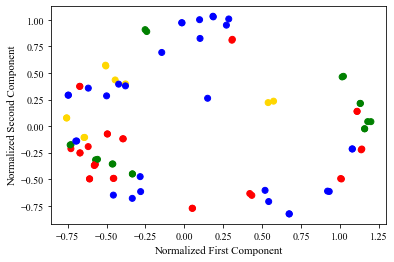

<Figure size 432x288 with 0 Axes>

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
pca = PCA(n_components=2)
delta_norm_normlize=normalize(delta_norm)
pca.fit(delta_norm_normlize)
print(pca.explained_variance_ratio_)
print(pca.components_)

colors=[]
for label in score2:
    if label == 1 or label == 2 or label == 3 :
        colors.append("r")
    elif label == 4 or label == 5 or label == 6:
        colors.append("g")
    elif label == 7 or label == 8 or label == 9:
        colors.append("gold")
    else:
        colors.append("b")
plt.rcParams["font.family"] = "Times New Roman"
X = pca.fit_transform(delta_norm_normlize)
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=colors)
plt.xlabel('Normalized First Component',fontsize=11)
plt.ylabel('Normalized Second Component',fontsize=11)

plt.show()

    # seq=np.argsort(importance1)
    # featureName=np.array(featureName)
    # featureName1=featureName[seq]
    # importance1=importance1[seq]
    # importance1=np.flip(importance1)
    # featureName1=np.flip(featureName1)


plt.savefig(r"C:\Sleep test\dyspnea\figure\pca1.tiff",dpi=600)



In [42]:
# artificially add extrem cases (5) to training set
# NCS +BIOPAC
data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_extreme_train.mat")
#data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_test.mat")
delta_Ncs_extreme = data['deltaNcs']
delta_Bio_extreme = data['deltaBio']
delta2_extreme=np.concatenate((delta_Ncs_extreme, delta_Bio_extreme),axis=0)
score_extreme=np.array([10,10,10,10,10,10,10,10,10,10])
score2_extreme=np.hstack((score_extreme,score_extreme))
group_extreme=np.array([2,2,3,3,4,4,5,5,6,6])
group2_extreme=np.hstack((group_extreme,group_extreme))
delta_norm_extrem=np.vstack([delta_norm,delta2_extreme])

y1=np.block([[score2,score2_extreme],[group_norm,group2_extreme]])
opt=['kfold','tree',7,7]
opt=['kfold','forest',8,8]
acc1,featureName1,importance1,tree1,accMean1=valid(delta_norm_extrem,y1,opt)
print(np.min(acc1),np.max(acc1))
#acc2,feature2,importance2,tree2,accMax2=valid_wo(delta_wo,y2,opt)
#acc3,feature3,importance3,tree3,accMax3=valid(feat,y3,opt)

# data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_extreme_test4.mat")

# delta_Ncs_extreme_test = data['deltaNcs']
# delta_Bio_extreme_test = data['deltaBio']
# delta2_extreme_test=np.concatenate((delta_Ncs_extreme_test, delta_Bio_extreme_test),axis=0)
# score_extreme_test=data['score'].ravel()
# score2_extreme_test=np.concatenate((score_extreme_test, score_extreme_test),axis=0)
# acc,label1=test_vote(delta2_extreme_test,score2_extreme_test,tree1)
# print(label1)



data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_test_with0_10.mat")
#data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_test.mat")
delta_Ncs_test = data['deltaNcs']
delta_Bio_test = data['deltaBio']
delta2_test=np.concatenate((delta_Ncs_test, delta_Bio_test),axis=0)
score_test=data['score_n'].ravel()
score2_test=np.hstack((score_test,score_test))
acc,label=test_vote(delta2_test,score2_test,tree1)
print(label)


0.892
0.8370238095238095 0.9319469696969698
0.889
[[ 3.    3.    5.    8.    8.    6.    4.    3.    0.    0.    0.   10.
  10.   10.   10.    3.    3.    5.    8.    8.    6.    4.    3.    0.
   0.    0.   10.   10.   10.   10.  ]
 [ 3.31  7.89  6.82  6.73  7.89  7.35  9.48  2.92  0.93  0.6   1.01  9.89
   9.89  9.93  9.94  3.13  3.27  7.06  8.45  7.84  3.59  9.77  2.24  0.87
   0.83  0.8   9.83  9.83  9.93  9.93]]


In [13]:

#rand_y = np.random.randint(0,11,size=len(score2_test)*10) 

acc_r_temp=[]
acc_c_temp=[]
for i in range(10):
    rand_y = np.random.randint(0,10,size=len(score2_test)) 
#score2_test_10=np.repeat(score2_test,10)

    cons_y=np.random.randint(i,i+1,size=len(score2_test)) 

    acc_r = 1-abs(score2_test-rand_y)/9
    acc_r=np.mean(acc_r)
    acc_r_temp.append(acc_r)

    acc_c = 1-abs(score2_test-cons_y)/9
    acc_c=np.mean(acc_c)
    acc_c_temp.append(acc_c)
acc_r_max=max(acc_r_temp) 
acc_r_min=min(acc_r_temp)
acc_c_max=max(acc_c_temp) 
acc_c_min=min(acc_c_temp)
print(acc_c_max,acc_c_min)
print(acc_r_max,acc_r_min)
print(acc_c_temp)

0.7777777777777778 0.3535353535353536
0.686868686868687 0.595959595959596
[0.6464646464646465, 0.6969696969696971, 0.7474747474747475, 0.7777777777777778, 0.7676767676767678, 0.7171717171717172, 0.6464646464646466, 0.5555555555555555, 0.4646464646464647, 0.3535353535353536]


In [15]:
data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_Ncs_norm.mat")
delta_norm = data['deltaNcs']
delta_norm_bio = data['deltaBio']
#scale_norm = data['scale_n'].ravel()
group_norm = data['group_norm'].ravel()
#y1=np.stack((scale_norm, group_norm))
y1=np.stack((score, group_norm))



# opt=['group','forest',8,8]

# acc1,feature1,importance1,tree1,accMax1=valid(delta_norm,y1,opt)
# acc2,feature2,importance2,tree2,accMax2=valid_wo(delta_wo,y2,opt)
# acc3,feature3,importance3,tree3,accMax3=valid(feat,y3,opt)

# data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_testNew.mat")
# #data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_test.mat")
# delta_Ncs_test = data['deltaNcs']
# delta_Bio_test = data['deltaBio']
# score_test=data['score_n'].ravel()

# acc,label1=test_vote(delta_Ncs_test[:,0:15],score_test,tree1)
# #acc,label2=test_vote(delta_Ncs_test[:,0:15],score_test,tree2)
# print(label1)




[0.4882624  0.23371925]
[[ 2.55930575e-02  6.70197829e-02 -3.71547084e-02  1.91849091e-02
   9.90905669e-01 -8.83552775e-02 -5.81443948e-02  1.54434255e-03
  -1.08556381e-08  1.29194402e-03  1.62731145e-03 -3.03246940e-03
   9.04909051e-04 -2.55446129e-03 -3.14279839e-04]
 [-3.52986779e-01 -2.77365174e-01 -6.25625929e-01 -6.36403618e-01
   1.64263150e-02  1.32861010e-02 -2.37731108e-02  4.16622651e-03
   7.27476076e-04  3.32438953e-03  3.65823303e-03 -1.18982919e-02
  -3.62137465e-03 -1.77531931e-02 -2.29747741e-02]]


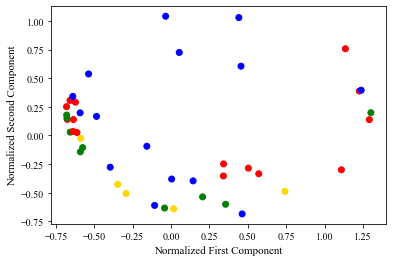

In [17]:

pca = PCA(n_components=2)
delta_norm_normlize=normalize(delta_norm[:,0:15])
pca.fit(delta_norm_normlize)
print(pca.explained_variance_ratio_)
print(pca.components_)

colors=[]
for label in score:
    if label == 1 or label == 2 or label == 3 :
        colors.append("r")
    elif label == 4 or label == 5 or label == 6:
        colors.append("g")
    elif label == 7 or label == 8 or label == 9:
        colors.append("gold")
    else:
        colors.append("b")

X = pca.fit_transform(delta_norm_normlize)
plt.scatter(X[:, 0], X[:, 1], c=colors)
plt.rcParams["font.family"] = "Times New Roman"


plt.xlabel('Normalized First Component',fontsize=11)
plt.ylabel('Normalized Second Component',fontsize=11)

plt.show()
#plt.savefig(r"C:\Sleep test\dyspnea\figure\pca1.png",dpi=600)

In [12]:
# artificially add extrem cases (5*2) to training set
data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_extreme_train.mat")
#data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_test.mat")
delta_Ncs_extreme = data['deltaNcs']
delta_Bio_extreme = data['deltaBio']
delta2_extreme=np.concatenate((delta_Ncs_extreme, delta_Bio_extreme),axis=0)
score_extreme=np.array([10,10,10,10,10,10,10,10,10,10])
score2_extreme=np.hstack((score_extreme,score_extreme))
group_extreme=np.array([2,2,3,3,4,4,5,5,6,6])
group2_extreme=np.hstack((group_extreme,group_extreme))
delta_norm_extreme=np.vstack([delta_norm,delta_Ncs_extreme[:,0:15]])
delta_norm_extreme_bio=np.vstack([delta_norm_bio,delta_Bio_extreme[:,0:15]])
opt=['kfold','tree',3,3]
#opt=['kfold','forest',3,3]
y1=np.block([[score,score_extreme],[group_norm,group_extreme]])

acc2,featureName2,importance2,tree2,accMean2=valid(delta_norm_extreme,y1,opt)
acc3,featureName3,importance3,tree3,accMean3=valid(delta_norm_extreme_bio,y1,opt)





data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_test_with0_10.mat")
#data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_test.mat")
delta_Ncs_test = data['deltaNcs']
delta_Bio_test = data['deltaBio']
score_test=data['score_n'].ravel()
acc,label1=test_vote(delta_Ncs_test[:,0:15],score_test,tree2)
acc,label1=test_vote(delta_Bio_test[:,0:15],score_test,tree3)




0.844
0.845
0.771
0.818


acc1_mean=0.892
FeatureImportance1:
r1 EX=0.401
sdnn=0.155
r2 BR=0.147
r2 EX=0.098
acc2_mean=0.87
FeatureImportance2:
r2 BR=0.378
r1 EX=0.184
r2 EX=0.106
r2 PP=0.085
acc3_mean=0.86
FeatureImportance3:
r2 BR=0.424
r1 EX=0.172
r2 EX=0.106
r2 PP=0.070


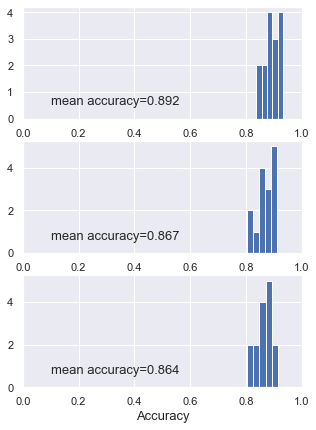

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(rc={"figure.figsize": (8, 15)}); np.random.seed(0)
size=13
s01='acc1_mean={n:.3f}\nFeatureImportance1:\n{n1}={s1:.3f}\n{n2}={s2:.3f}\n{n3}={s3:.3f}\n{n4}={s4:.3f}'.format(n=accMean1,n1=featureName1[0],s1=importance1[0],
    n2=featureName1[1],s2=importance1[1],n3=featureName1[2],s3=importance1[2],n4=featureName1[3],s4=importance1[3])
s02='acc2_mean={n:.2f}\nFeatureImportance2:\n{n1}={s1:.3f}\n{n2}={s2:.3f}\n{n3}={s3:.3f}\n{n4}={s4:.3f}'.format(n=accMean2,n1=featureName2[0],s1=importance2[0],
    n2=featureName2[1],s2=importance2[1],n3=featureName2[2],s3=importance3[2],n4=featureName3[3],s4=importance2[3])
s03='acc3_mean={n:.2f}\nFeatureImportance3:\n{n1}={s1:.3f}\n{n2}={s2:.3f}\n{n3}={s3:.3f}\n{n4}={s4:.3f}'.format(n=accMean3,n1=featureName3[0],s1=importance3[0],
    n2=featureName3[1],s2=importance3[1],n3=featureName3[2],s3=importance3[2],n4=featureName3[3],s4=importance3[3])
s1='mean accuracy={n:.3f}\n'.format(n=accMean1)
s2='mean accuracy={n:.3f}\n'.format(n=accMean2)
s3='mean accuracy={n:.3f}\n'.format(n=accMean3)

plt.figure(figsize=(5,7))
plt.subplot(3,1,1)
plt.hist(acc1, bins=5,density=False)
plt.xlim((0, 1))
plt.text(0.1,0,s1,fontsize=size)
plt.subplot(3,1,2)
plt.hist(acc2, bins=5, density=False)
plt.xlim((0, 1))
plt.xlabel('Accuracy',fontsize=size)
plt.text(0.1,0,s2,fontsize=size)
plt.subplot(3,1,3)
plt.hist(acc3, bins=5, density=False)
plt.xlim((0, 1))
plt.xlabel('Accuracy',fontsize=size)
plt.text(0.1,0,s3,fontsize=size)


#plt.savefig(r"C:\Sleep test\dyspnea\figure\acc_kfold3.png",dpi=600)
print(s01)
print(s02)
print(s03)
#from scipy.io import savemat

#mdic = {"a": a, "label": "experiment"}
#savemat(r"C:\Sleep test\dyspnea\data\all\plot\acc_kfold.png", mdic)